In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xg


In [235]:
filepath = os.path.join(os.getcwd(), "df.csv")
df = pd.read_csv(filepath)
df.head(10)

,stadium,birthdate,date1,time1,distance1,trap1,comment1,date2,distance2,trap2,time2
0,Central Park,2018-12-01,2020-12-07,17.13,265,5,"slow away, middle to wide",2020-12-15,265,6,17.09
1,Central Park,2018-12-01,2020-12-15,17.09,265,6,"wide, led half",2020-12-22,265,6,16.81
2,Central Park,2018-12-01,2020-12-22,16.81,265,6,"wide, missed trouble and led first",2021-01-12,265,6,17.32
3,Central Park,2018-12-01,2021-01-12,17.32,265,6,"badly crowded half, badly baulked second",2021-01-19,265,6,17.10
4,Central Park,2018-12-01,2021-01-19,17.10,265,6,"wide, challenged run in",2021-01-27,265,6,16.84
5,Central Park,2018-12-01,2021-01-27,16.84,265,6,"quick away, wide, challenged near line",2021-02-03,265,6,16.93
6,Central Park,2018-12-01,2021-05-19,17.36,265,5,very wide first,2021-05-27,265,6,17.08
7,Central Park,2018-12-01,2021-05-27,17.08,265,6,"early pace, middle to wide, led near line",2021-06-08,265,6,16.66
8,Central Park,2018-12-01,2021-06-08,16.66,265,6,"early pace, wide, soon led",2021-06-15,265,6,17.07
9,Central Park,2018-12-01,2021-06-15,17.07,265,6,"early pace, wide, every chance",2021-06-28,265,5,17.17


In [236]:
df = df.drop(columns = ["comment1"])
df = pd.get_dummies(df, prefix = "stadium_", columns = ["stadium"])

In [237]:
df['birthdate'] = pd.to_datetime(df['birthdate'])
df['date1'] = pd.to_datetime(df['date1'])
df['date2'] = pd.to_datetime(df['date2'])

In [238]:
df["day_age_1"] = (df['date1'] - df['birthdate']).dt.days
df["day_age_2"] = (df['date2'] - df['birthdate']).dt.days
df["days_between_race"] = (df['date2'] - df['date1']).dt.days

df = df.drop(columns = ["birthdate", "date1", "date2"])

In [239]:
df.dtypes

time1                     float64
distance1                   int64
trap1                       int64
distance2                   int64
trap2                       int64
time2                     float64
stadium__Central Park        bool
stadium__Crayford            bool
stadium__Doncaster           bool
stadium__Harlow              bool
stadium__Henlow              bool
stadium__Hove                bool
stadium__Kinsley             bool
stadium__Monmore             bool
stadium__Newcastle           bool
stadium__Nottingham          bool
stadium__Oxford              bool
stadium__Pelaw Grange        bool
stadium__Perry Barr          bool
stadium__Romford             bool
stadium__Sheffield           bool
stadium__Suffolk Downs       bool
stadium__Sunderland          bool
stadium__Swindon             bool
stadium__Towcester           bool
stadium__Yarmouth            bool
day_age_1                   int64
day_age_2                   int64
days_between_race           int64
dtype: object

In [240]:
numerical_cols = list(df.select_dtypes(include = "number").columns)

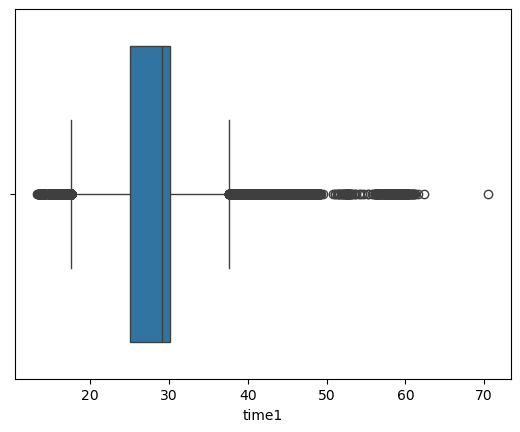

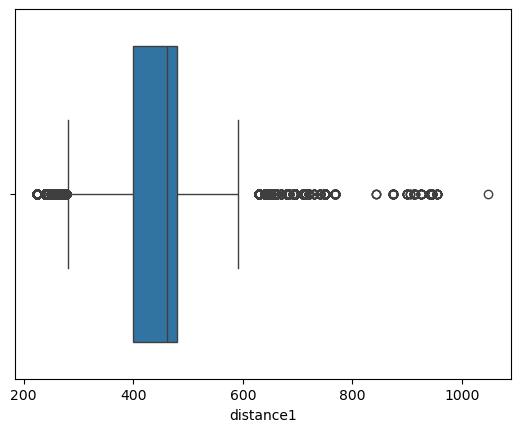

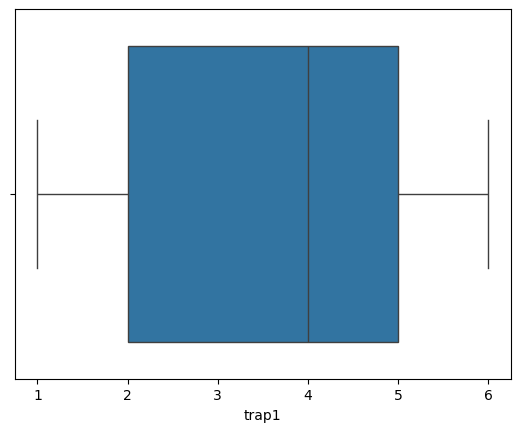

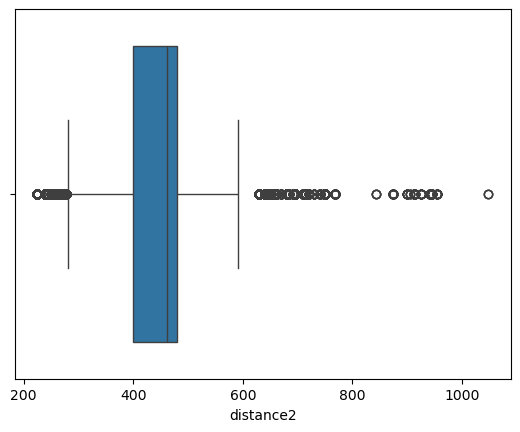

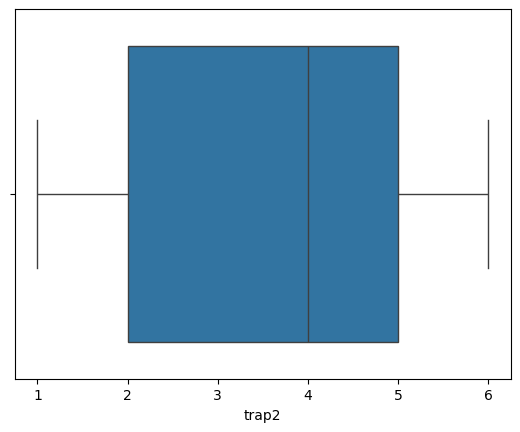

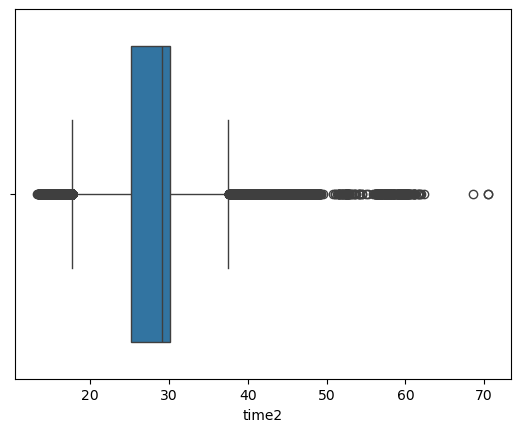

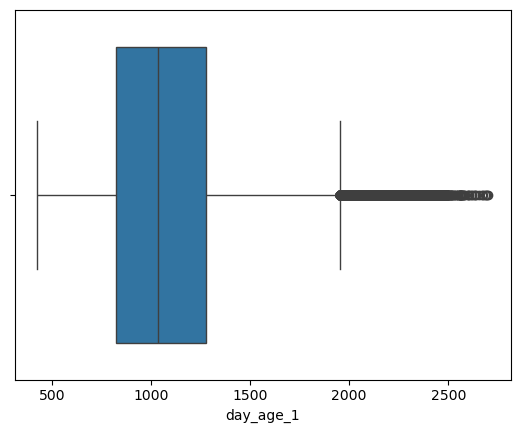

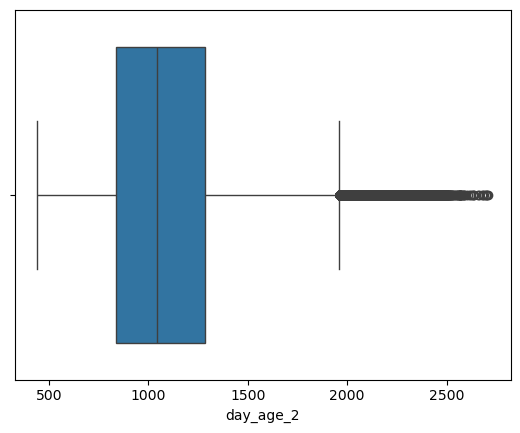

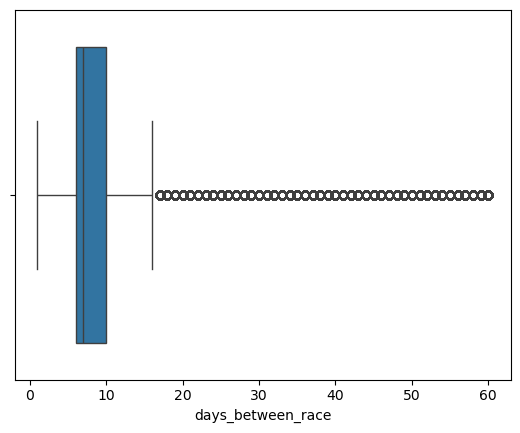

In [241]:
for col in numerical_cols:
    sns.boxplot(data = df, x = col)
    plt.show(   )


In [242]:
X = df.drop(columns = ["time2"])
y = df["time2"]


In [243]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [244]:
# scores = cross_validate(xgb_r, X_scaled, y, cv = 20, scoring = "neg_mean_squared_error", return_train_score = True)

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.1, random_state = 42)

In [246]:
grid = {
    "booster" : ["gbtree"],
    "eval_metric" : ["rmse"],
    "eta" : [0.1, 0.15, 0.17],
    "lambda" : [1.1, 1.5, 1.8],
    "n_estimators" : [330, 350, 370]
}

In [247]:
xgb_grid = GridSearchCV(xg.XGBRegressor(), param_grid = grid, cv = 5, scoring = "neg_mean_squared_error", refit="neg_mean_squared_error")

In [248]:
xgb_grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [212]:
xgb_grid.best_params_

{'booster': 'gbtree',
 'eta': 0.15,
 'eval_metric': 'rmse',
 'lambda': 1.5,
 'n_estimators': 350}

In [213]:
best_xg = xg.XGBRegressor(booster = "gbtree", eta = 0.15, reg_lambda = 1.5, eval_metric = "rmse",n_estimators = 350 )

In [214]:
best_xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=350,
             n_jobs=None, num_parallel_tree=None, ...)

In [215]:
y_pred = best_xg.predict(X_test)

In [216]:
mean_squared_error(y_test, y_pred)

0.14853164729298746